# Customer Segmentation Report

The main bulk of our analysis will come in this part of the project. Here, we use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import missingno as msno

from time import time
from collections import OrderedDict, Counter

from tqdm.auto import tqdm, trange
tqdm.pandas()

from utils.transformers import *
from utils.functions import *

import pyarrow

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# magic word for producing visualizations in notebook
%matplotlib inline

## Load the Data

In [2]:
azdias = pd.read_parquet('temp/azdias_processed.gzip')
azdias.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,1,0,0,0,0,0,0,0,0,1,...,-0.359845,-0.292527,-0.302057,-0.098898,0.023455,-0.395656,-0.000407,0.137664,0.018645,910215
1,0,1,0,0,0,0,0,0,0,1,...,-0.359845,-0.292527,0.357993,0.048946,0.023455,-0.519516,0.731728,1.102566,1.527603,910220
2,0,1,0,0,0,1,0,0,0,0,...,-0.359845,-0.292527,-0.008701,-0.542432,-2.641994,-0.395656,1.097796,0.459298,0.018645,910225
3,0,1,0,1,0,0,0,0,0,0,...,1.213535,-0.292527,-0.375395,-0.838120,-0.376363,-0.519516,0.365661,0.780932,1.904842,910226
4,1,0,0,0,0,0,0,1,0,0,...,-0.359845,-0.292527,-0.302057,0.048946,0.023455,-0.395656,-1.098609,-0.827238,-0.735833,910241


In [3]:
azdias = azdias.drop('LNR', axis=1)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 0 to 891220
Columns: 685 entries, ANREDE_KZ_1 to VK_ZG11
dtypes: float32(15), uint8(670)
memory usage: 627.3 MB


## Dimensionality Reduction

Investigate the variance accounted for by each principal component.

### Utility Functions

In [9]:
def pca_results(full_dataset, pca, show_plot=True):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance Ratio'])
    variance_ratios.index = dimensions
    
    # PCA explained cumulative variance
    cumsum = pca.explained_variance_ratio_.cumsum().reshape(len(pca.components_), 1)
    variance_cumsum = pd.DataFrame(np.round(cumsum, 4), columns = ['Explained Cumulative Variance'])
    variance_cumsum.index = dimensions

    if show_plot == True:
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))
        ax.plot(np.arange(len(variance_cumsum)), variance_cumsum)
        ax.set_ylabel("Explained Cumulative Variance")
        ax.set_xlabel("Number of Principal Components")

    # Return a concatenated DataFrame
    return pd.concat([variance_cumsum, variance_ratios, components], axis = 1)

In [17]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def print_pcs(df, pca, comp, k=5):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    pc = components.iloc[comp-1].sort_values(ascending=False)
    print(f'Weights for PC{comp}')
    print(f'Top {k} weights')
    print(pc.head(k))
    print('\n')
    print(f'Bottom {k} weights')
    print(pc.tail(k))

In [163]:
def comp_weights(pca, dimension_max, dimension_min , num_features, df):
    components = pd.DataFrame( np.round(pca.components_, 4), columns = df.keys())
    components.index = [i for i in range(1, len(pca.components_)+1)]

    weights_pos = components.iloc[dimension_max-1]
    weights_neg = components.iloc[dimension_min-1]
    fig, ax = plt.subplots(figsize = (15, 4), ncols=2, nrows = 1)
    weights_pos.sort_values(ascending=False)[:num_features].plot(kind='bar', ax = ax[0]);
    weights_neg.sort_values(ascending=False)[-num_features:].plot(kind='bar', ax = ax[1], color = 'red');
    
    return fig

### PCA

Apply PCA to the data

In [6]:
pca = PCA(random_state=777)
pca.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=777,
    svd_solver='auto', tol=0.0, whiten=False)

,Explained Cumulative Variance,Explained Variance Ratio,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,...,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11
Dimension 1,0.1488,0.1488,0.0003,-0.0003,0.0018,0.0052,0.0041,0.0049,0.0013,0.0004,...,0.0114,0.0196,0.0330,-0.0177,0.0082,0.0080,-0.0029,-0.0830,-0.0716,-0.0498
Dimension 2,0.2154,0.0666,0.0069,-0.0069,-0.0048,-0.0112,-0.0088,-0.0103,-0.0019,-0.0033,...,-0.0350,-0.0079,0.0143,0.0383,0.0594,-0.0125,0.0179,-0.0009,0.0282,0.0493
Dimension 3,0.2699,0.0544,-0.0206,0.0206,0.0000,-0.0085,-0.0085,-0.0132,0.0003,0.0018,...,-0.0368,-0.0288,-0.0215,0.0650,-0.0029,0.0077,0.0407,0.0182,0.0040,-0.0025
Dimension 4,0.3164,0.0465,0.0172,-0.0172,0.0081,0.0079,0.0014,0.0015,0.0059,-0.0025,...,0.0399,-0.0150,0.0058,-0.0079,0.0051,-0.0088,0.0101,0.0013,0.0061,0.0092
Dimension 5,0.3595,0.0431,0.0890,-0.0890,-0.0000,-0.0003,0.0006,-0.0003,0.0004,0.0040,...,-0.0105,-0.0005,-0.0104,0.0230,-0.0092,0.0000,0.0154,0.0108,-0.0181,-0.0467
Dimension 6,0.3818,0.0222,0.0370,-0.0370,-0.0001,-0.0046,-0.0047,-0.0129,-0.0041,-0.0050,...,-0.0516,0.0217,-0.0367,-0.0148,-0.0196,0.0149,-0.0091,-0.0193,-0.0388,-0.0684
Dimension 7,0.4023,0.0206,-0.0246,0.0246,0.0043,0.0059,0.0031,0.0020,0.0019,0.0061,...,-0.0535,-0.0020,0.0269,0.0279,0.0107,0.0012,0.0364,-0.0161,-0.0173,-0.0050
Dimension 8,0.4199,0.0175,-0.0235,0.0235,-0.0055,-0.0085,0.0003,0.0008,0.0023,0.0053,...,0.0681,0.0257,-0.0090,0.0530,0.0843,-0.0088,-0.0052,0.0648,0.0749,0.0837
Dimension 9,0.4365,0.0167,-0.0279,0.0279,0.0043,0.0061,0.0028,0.0019,-0.0002,0.0048,...,0.0025,-0.0144,-0.0077,-0.0248,0.0240,0.0078,0.0020,0.0071,0.0080,0.0116
Dimension 10,0.4515,0.0150,0.0083,-0.0083,-0.0048,-0.0038,-0.0033,0.0051,-0.0009,-0.0076,...,-0.0820,-0.0164,-0.0050,0.0258,-0.0212,-0.0035,-0.0084,0.0131,0.0189,0.0174


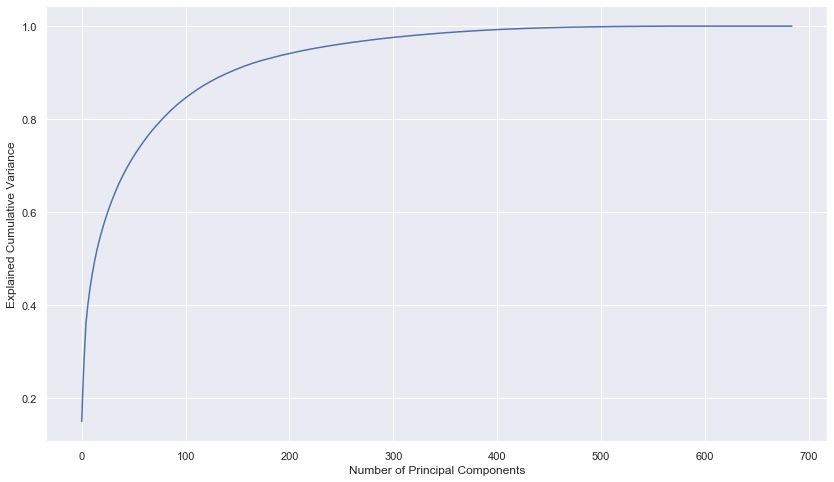

In [10]:
results = pca_results(azdias, pca)
results

Pick a number of components

In [15]:
n_components = 150

In [16]:
explained_variance = results.iloc[n_components, 0]
explained_variance

0.9082

Re-apply PCA to the data while selecting for number of components to retain

In [18]:
pca = PCA(n_components=n_components, random_state=777)
azdias_pca = pca.fit_transform(azdias)

### PCA Results

In [21]:
print_pcs(azdias, pca, comp=1)

Weights for PC1
Top 5 weights
D19_GESAMT_ONLINE_QUOTE_12     0.4903
D19_VERSAND_ONLINE_QUOTE_12    0.4737
ONLINE_AFFINITAET              0.1393
D19_BANKEN_ONLINE_QUOTE_12     0.0913
D19_GESAMT_ANZ_12              0.0885
Name: 0, dtype: float64


Bottom 5 weights
W_KEIT_KIND_HH             -0.0958
D19_VERSAND_ONLINE_DATUM   -0.2964
D19_VERSAND_DATUM          -0.2990
D19_GESAMT_ONLINE_DATUM    -0.3124
D19_GESAMT_DATUM           -0.3141
Name: 0, dtype: float64


In [22]:
print_pcs(azdias, pca, comp=2)

Weights for PC2
Top 5 weights
ALTER_HH         0.3310
SEMIO_REL        0.2465
SEMIO_PFLICHT    0.2112
FINANZ_SPARER    0.2055
ORTSGR_KLS9      0.1711
Name: 1, dtype: float64


Bottom 5 weights
MOBI_REGIO          -0.1399
FINANZ_MINIMALIST   -0.1573
FINANZ_VORSORGER    -0.1607
SEMIO_LUST          -0.1662
SEMIO_ERL           -0.1789
Name: 1, dtype: float64


In [23]:
print_pcs(azdias, pca, comp=3)

Weights for PC3
Top 5 weights
ORTSGR_KLS9         0.3036
EWDICHTE            0.2092
SEMIO_ERL           0.1452
FINANZ_HAUSBAUER    0.1156
SEMIO_LUST          0.1153
Name: 2, dtype: float64


Bottom 5 weights
FINANZ_ANLEGER   -0.1413
SEMIO_REL        -0.1725
INNENSTADT       -0.2327
BALLRAUM         -0.2348
ALTER_HH         -0.2721
Name: 2, dtype: float64


In [24]:
pca.explained_variance_ratio_.cumsum()

array([0.14879457, 0.21543767, 0.2698714 , 0.31638538, 0.35952412,
       0.38175618, 0.4023303 , 0.41986534, 0.43653928, 0.45154193,
       0.46499263, 0.47805131, 0.48984636, 0.50086212, 0.51157054,
       0.52141132, 0.53100713, 0.5398324 , 0.54814447, 0.55626691,
       0.56420539, 0.57179247, 0.57917487, 0.58632662, 0.59314383,
       0.59963251, 0.60606662, 0.61235082, 0.61846485, 0.62437557,
       0.63012401, 0.63579734, 0.64137774, 0.64671545, 0.65187342,
       0.6569394 , 0.66195205, 0.66670932, 0.67143234, 0.67589032,
       0.68026605, 0.68456008, 0.68880638, 0.69302904, 0.69707645,
       0.70107254, 0.7050183 , 0.70888582, 0.71259461, 0.71629607,
       0.71987792, 0.72340219, 0.72689514, 0.73034185, 0.73372489,
       0.73703295, 0.74028574, 0.74353046, 0.74667187, 0.74979614,
       0.75289535, 0.75593423, 0.75892637, 0.7618655 , 0.7647813 ,
       0.76764514, 0.77049595, 0.77329392, 0.7760069 , 0.77866851,
       0.78130755, 0.78390968, 0.78644534, 0.78895741, 0.79141

In [25]:
dump(pca, 'temp/pca.joblib')

['temp/pca.joblib']

## Clustering

In [28]:
scores = []

clusters = list(range(2,16,1))
# Over a number of different cluster counts...
for k in clusters:
    # run k-means clustering on the data and...
    print(f'Running KMeans with {k} cluster(s)')
    start = time() # Get start time
    kmeans = KMeans(n_clusters = k, random_state=777)
    model = kmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    score = model.score(azdias_pca)
    scores.append(np.abs(score))
    
    end = time() # Get end time
    m, s = divmod(end - start, 60)
    print(f'Finished KMeans with {k} cluster(s) in {m}m:{s}s')

Running KMeans with 2 cluster(s)
Finished KMeans with 2 cluster(s) in 0.0m:53.3224892616272s
Running KMeans with 3 cluster(s)
Finished KMeans with 3 cluster(s) in 2.0m:1.0543417930603027s
Running KMeans with 4 cluster(s)
Finished KMeans with 4 cluster(s) in 2.0m:23.61949372291565s
Running KMeans with 5 cluster(s)
Finished KMeans with 5 cluster(s) in 4.0m:56.41005301475525s
Running KMeans with 6 cluster(s)
Finished KMeans with 6 cluster(s) in 5.0m:15.610645055770874s
Running KMeans with 7 cluster(s)
Finished KMeans with 7 cluster(s) in 6.0m:6.284068584442139s
Running KMeans with 8 cluster(s)
Finished KMeans with 8 cluster(s) in 7.0m:51.431763648986816s
Running KMeans with 9 cluster(s)
Finished KMeans with 9 cluster(s) in 7.0m:45.77589559555054s
Running KMeans with 10 cluster(s)
Finished KMeans with 10 cluster(s) in 7.0m:57.756840467453s
Running KMeans with 11 cluster(s)
Finished KMeans with 11 cluster(s) in 9.0m:9.520852327346802s
Running KMeans with 12 cluster(s)
Finished KMeans with 1

Investigate the change in within-cluster distance across number of clusters

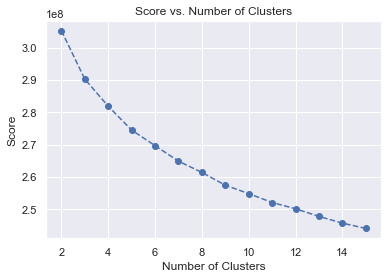

In [29]:
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of Clusters');
plt.ylabel('Score');
plt.title('Score vs. Number of Clusters')
plt.savefig('temp/kmeans.png')
plt.show()

Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data

In [30]:
kmeans = KMeans(n_clusters = 8, random_state=777)
kmeans = kmeans.fit(azdias_pca)

In [31]:
population_labels = kmeans.labels_

In [32]:
dump(kmeans, 'temp/kmeans_model.joblib')

['temp/kmeans_model.joblib']

## Customers data

In [56]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Load the preprocessing pipeline and apply on customers

In [57]:
clean_pipeline = load('temp/preprocessing_pipeline.joblib') 

In [58]:
extra_columns = ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
customers_extra = customers[extra_columns + ['LNR']]
customers = customers.drop(extra_columns, axis=1)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [59]:
customers = clean_pipeline.transform(customers)
azdias = pd.read_parquet('temp/azdias_processed.gzip')
customers = pd.DataFrame(customers, columns=azdias.columns)
customers.head()

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,MIN_GEBAEUDEJAHR,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.448734,-1.429498,0.823089,0.471363,-0.366474,-1.470506,-1.490312,9626.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.302057,0.492479,-0.642908,-0.395656,-0.000407,-0.505604,-1.113073,9628.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.448734,-1.133809,-1.042725,-0.519516,1.463863,1.745834,1.904842,143872.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.359845,-0.292527,-0.448734,-0.985965,-3.175084,-0.519516,-0.000407,-1.148872,-1.490312,143873.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.359845,-0.292527,-0.008701,-0.985965,0.023455,-0.395656,-1.098609,-0.827238,-0.735833,143874.0


Reduce the memory used by the dataset

In [60]:
customers_extra, _ = reduce_mem_usage(customers_extra)
customers, _ = reduce_mem_usage(customers)

Memory usage of dataframe:  5.8488311767578125  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 3.8383216857910156 MB
This is 65.63% of the initial size
Memory usage of dataframe:  1003.0615386962891  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 134.15589141845703 MB
This is 13.37% of the initial size


Put back the extra columns

In [61]:
customers_exta = pd.merge(customers, customers_extra, how='inner', on='LNR')
customers_exta.head()

,ANREDE_KZ_1,ANREDE_KZ_2,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,...,EINGEZOGENAM_HH_JAHR,EXTSEL992,VERDICHTUNGSRAUM,VK_DHT4A,VK_DISTANZ,VK_ZG11,LNR,ONLINE_PURCHASE,PRODUCT_GROUP,CUSTOMER_GROUP
0,1,0,1,0,0,0,0,0,0,0,...,-1.429498,0.823089,0.471363,-0.366474,-1.470505,-1.490312,9626,0,COSMETIC_AND_FOOD,MULTI_BUYER
1,1,0,0,1,0,0,0,0,0,0,...,0.492479,-0.642908,-0.395656,-0.000407,-0.505604,-1.113073,9628,0,FOOD,SINGLE_BUYER
2,0,1,0,0,0,0,1,0,0,0,...,-1.133809,-1.042725,-0.519516,1.463863,1.745834,1.904842,143872,0,COSMETIC_AND_FOOD,MULTI_BUYER
3,1,0,0,0,0,1,0,0,0,0,...,-0.985965,-3.175084,-0.519516,-0.000407,-1.148872,-1.490312,143873,0,COSMETIC,MULTI_BUYER
4,1,0,0,0,0,0,0,0,1,0,...,-0.985965,0.023455,-0.395656,-1.098609,-0.827238,-0.735833,143874,0,FOOD,MULTI_BUYER


In [62]:
customers_exta.to_parquet('temp/customers_processed.gzip', compression='gzip')

C:\Users\radue\Anaconda3\envs\udacity_ml_capstone\lib\site-packages\pyarrow\pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


Apply PCA

In [63]:
customers = customers.drop('LNR', axis=1)
customers_pca = pca.transform(customers)

Obtain clustering predictions

In [64]:
customers_labels = kmeans.predict(customers_pca)

Construct dictionary that maps cluster labels to frequency in customer population

In [67]:
counts_customer = Counter(customers_labels)
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

Construct dictionary that maps cluster labels to frequency in general population

In [69]:
counts_population = Counter(population_labels)
n_population = azdias_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population

In [83]:
customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

In [88]:
all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

,% of data,Cluster,DataSet
0,22.314403,0,Customers Data
1,9.328888,1,Customers Data
2,23.881827,2,Customers Data
3,14.220045,3,Customers Data
5,3.389999,5,Customers Data
4,0.918853,4,Customers Data
7,24.361342,7,Customers Data
6,1.584643,6,Customers Data
7,8.802194,7,General Population
6,13.934591,6,General Population


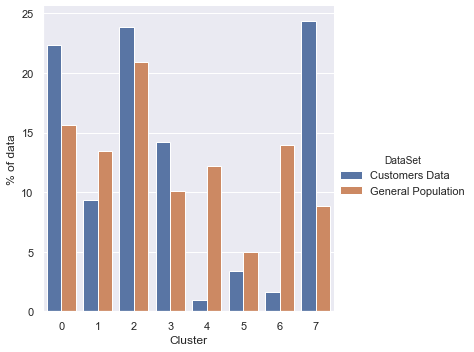

In [106]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

In [115]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over_cluster = 7

print(f'Proportion of general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'Proportion of customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')

pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)

pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)

pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

Proportion of general population in cluster 7: 8.802193844175575%
Proportion of customer population in cluster 7: 24.3613424331601%



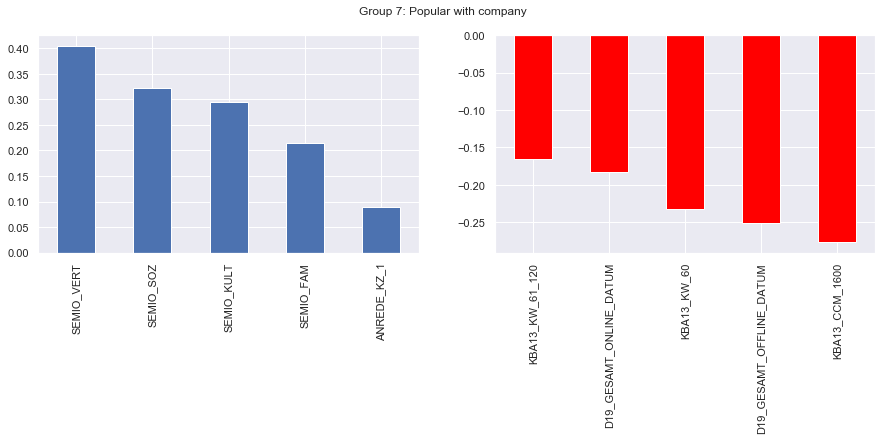

In [165]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 5, customers)
plt.suptitle(f'Group {over_cluster}: Popular with company');
plt.savefig('temp/over_cluster.png', dpi=fig.dpi, bbox_inches='tight')

In [168]:
pca_inverse = pca.inverse_transform(kmeans.cluster_centers_[over_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers.columns)

scaler = clean_pipeline.named_steps['transform_pipeline'].transformers_[2][1].named_steps['std_scaler']
df[numeric_features] = scaler.inverse_transform(df[numeric_features])

popular_features = ['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KULT', 'SEMIO_FAM', 'ANREDE_KZ_1']
print('Popular with company')
df[popular_features]

Popular with company


,SEMIO_VERT,SEMIO_SOZ,SEMIO_KULT,SEMIO_FAM,ANREDE_KZ_1,ANREDE_KZ_2
0,1.093707,2.018105,2.987535,5.889674,0.419833,0.580167


In [152]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under_cluster = 4

print(f'Proportion of general population in cluster {under_cluster}: {population_freqs[under_cluster]}%')
print(f'Proportion of customer population in cluster {under_cluster}: {customer_freqs[under_cluster]}%\n')

pc1_avg = (azdias_pca[population_labels == under_cluster][0].sum() + customers_pca[customers_labels == under_cluster][0].sum()) / \
          (n_population + n_customers)

pc2_avg = (azdias_pca[population_labels == under_cluster][1].sum() + customers_pca[customers_labels == under_cluster][1].sum()) / \
          (n_population + n_customers)

pc3_avg = (azdias_pca[population_labels == under_cluster][2].sum() + customers_pca[customers_labels == under_cluster][2].sum()) / \
          (n_population + n_customers)

Proportion of general population in cluster 4: 12.191701048337057%
Proportion of customer population in cluster 4: 0.9188529209191659%



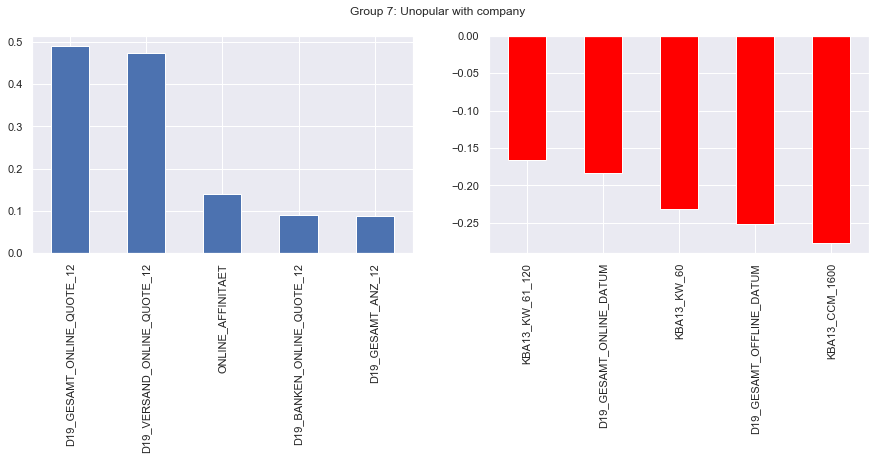

In [166]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series(kmeans.cluster_centers_[under_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[under_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 5, customers)
plt.suptitle(f'Group {over_cluster}: Unopular with company');
plt.savefig('temp/under_cluster.png', dpi=fig.dpi, bbox_inches='tight')

In [167]:
pca_inverse = pca.inverse_transform(kmeans.cluster_centers_[under_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers.columns)

scaler = clean_pipeline.named_steps['transform_pipeline'].transformers_[2][1].named_steps['std_scaler']
df[numeric_features] = scaler.inverse_transform(df[numeric_features])

unpopular_features = ['D19_GESAMT_ONLINE_QUOTE_12', 
                      'D19_VERSAND_ONLINE_QUOTE_12', 
                      'ONLINE_AFFINITAET', 
                      'D19_BANKEN_ONLINE_QUOTE_12', 
                      'D19_GESAMT_ANZ_12']
print('Unpopular with company')
df[unpopular_features]

Unpopular with company


,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,ONLINE_AFFINITAET,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12
0,0.088116,0.013217,2.217593,0.012309,1.037286


## Results - Compare Customer Data to Demographics Data

**Popular with company - Cluster 7**

* SEMIO_VERT (1) # affinity indicating in what way the person is dreamily (highest affinity)
* SEMIO_SOZ (2) # affinity indicating in what way the person is social minded (very high affinity)
* SEMIO_KULT (3) # affinity indicating in what way the person is cultural minded (high affinity)
* SEMIO_FAM (6) # affinity indicating in what way the person is familiar minded (very low affinity)
* ANREDE_KZ_1 (0) # gender: female

**Unpopular with company - Cluster 4**

* D19_GESAMT_ONLINE_QUOTE_12 (0) # amount of online transactions within all transactions in the complete file: no Online-transactions within the last 12 months
* D19_VERSAND_ONLINE_QUOTE_12 (0) # amount of online transactions within all transactions in the segment mail-order: no Online-transactions within the last 12 months
* ONLINE_AFFINITAET (2) # online affinity: (average affinity)
* D19_BANKEN_ONLINE_QUOTE_12 (0) # amount of online transactions within all transactions in the segment bank: no Online-transactions within the last 12 months
* D19_GESAMT_ANZ_12 (1) # transaction activity TOTAL POOL in the last 12 months: very low activity